In [121]:
import anndata
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [122]:
u_tax_csv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

# Compare kb --aa viral loads of known virus vs qPCR/RNAish

# 1. Data from https://www.nature.com/articles/s41467-020-20139-7:
"For Total RNA-sequencing, The Smarter Stranded Total RNA-Seq kit v2 (634413, Takara) was used with 10 ng RNA input, according to the manufacturer instructions to generate libraries. Dual-indexed pooled libraries were sequenced on the Illumina NextSeq 500 platform using a 150 cycles kit with paired end read mode."

In [123]:
adata = anndata.read(f"/home/laura/projects/virus-watch-data/PRJNA631753/PRJNA631753_combined_meta.h5ad")
adata

AnnData object with n_obs × n_vars = 176 × 99228
    obs: 'case', 'read'

In [124]:
# Load RNAish % from paper
rna_ish = pd.read_csv("/home/laura/projects/virus-watch/bulk/covid_PRJNA631753/rna_ish_counts.csv", sep="\t")
rna_ish["case_clean"] = rna_ish["case_clean"].values.astype(str)
rna_ish

,case_clean,Case,Virus High/Low,Viral load% by RNA ISH
0,1,Case 1,High,81.200
1,2,Case 2,Low,0.500
2,3,Case 3,Low,2.000
3,4,Case 4,Low,0.009
4,5,Case 5,High,18.500
5,6,Case 6,Low,0.020
6,7,Case 7,High,6.200
7,8,Case 8,High,23.500
8,9,Case 9,High,89.700
9,10,Case 10,Low,0.000


In [125]:
case_list = ["Control", "10", "20", "4", "12", "13", "19", "B", "6", "14", "17", "2", "3", "18", "16", "7", "15", "5", "8", "D", "11", "C", "1", "9"]

In [126]:
tax_df = pd.read_csv(u_tax_csv)
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


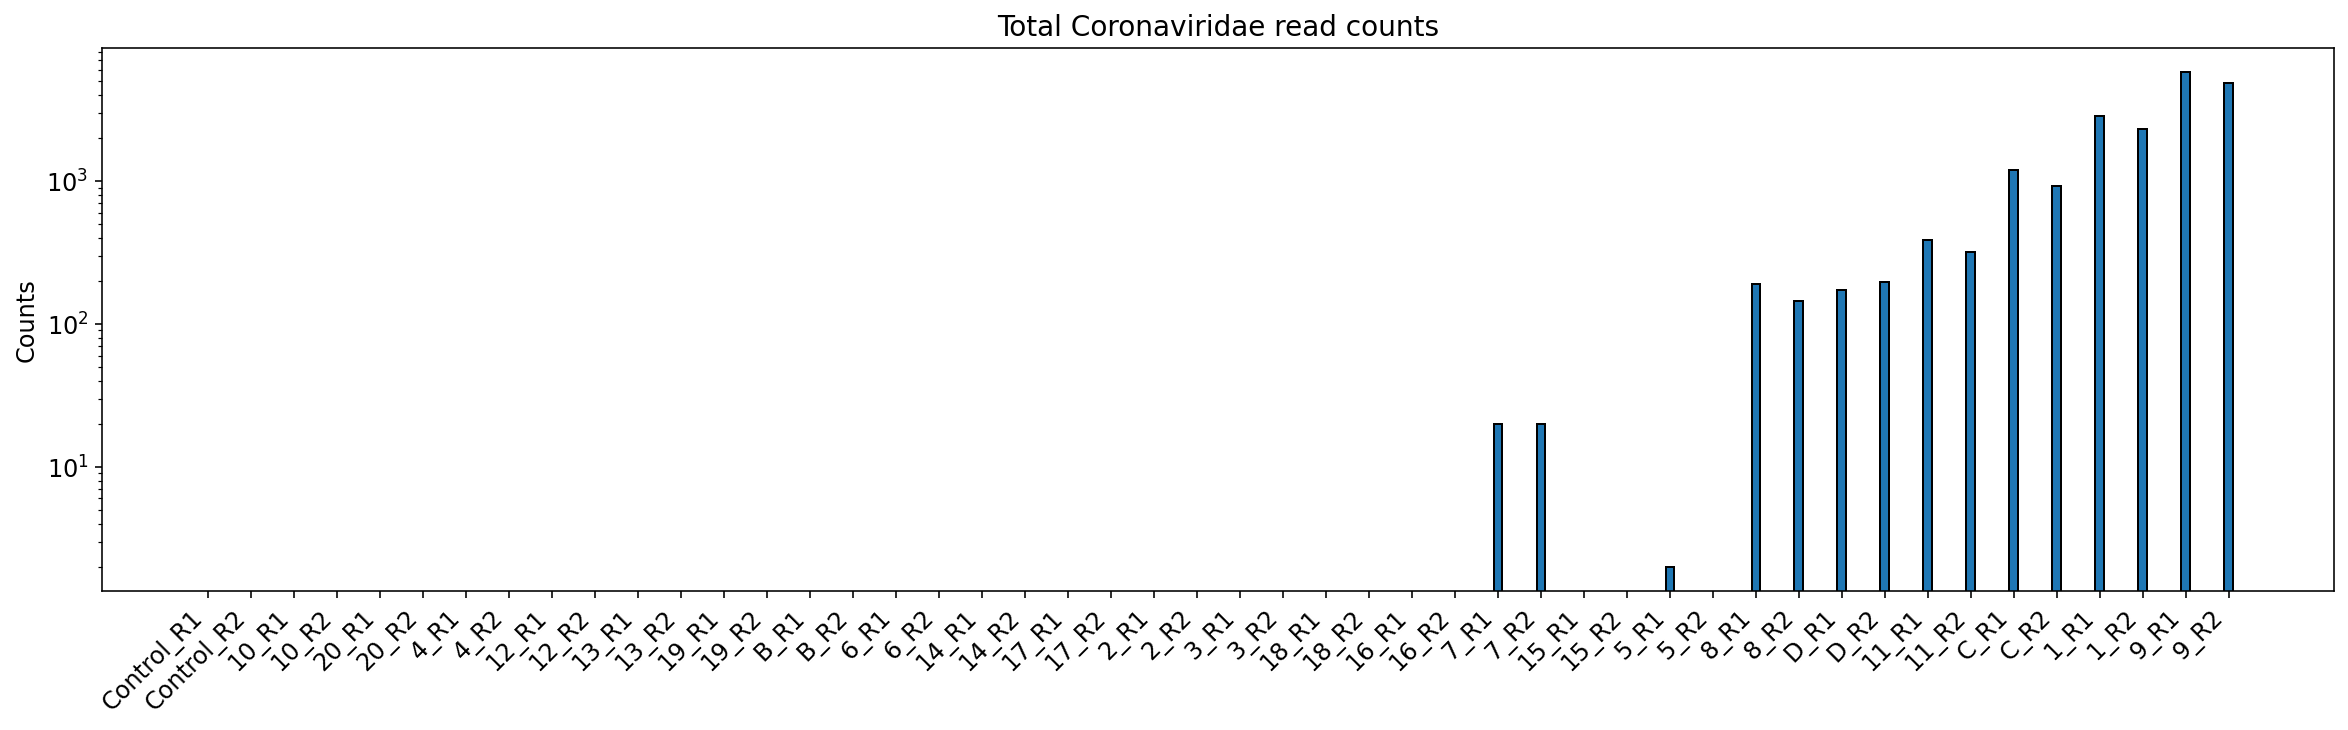

In [127]:
fig, ax = plt.subplots(figsize=(20, 5))

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].values

counts1 = []
samples = []
for case in case_list:
    counts1.append(adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R1"), adata.var.index.isin(target_ids)].X.sum())
    counts1.append(adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R2"), adata.var.index.isin(target_ids)].X.sum())
    
    samples.append("_".join([case, "R1"]))
    samples.append("_".join([case, "R2"]))

fontsize=12
width = 0.2
x = np.arange(len(samples))

ax.bar(x, counts1, width=width, edgecolor="black")

# ax.bar(x+0.5*width, viral_load, width=width, label="RT-qPCR (copies/mL)", edgecolor="black", color="white", hatch="/")

ax.set_yscale("log")
ax.set_ylabel("Counts", fontsize=fontsize)
# ax.legend(fontsize=fontsize)

ax.set_xticks(x, samples, rotation=45, ha="right")
# # Mark positive samples 
# for i, sample in enumerate(samples):
#     if pos[i]:
#         plt.gca().get_xticklabels()[i].set_color("red") 
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Total Coronaviridae read counts", fontsize=fontsize+2)
    
# plt.tight_layout()

fig.show()

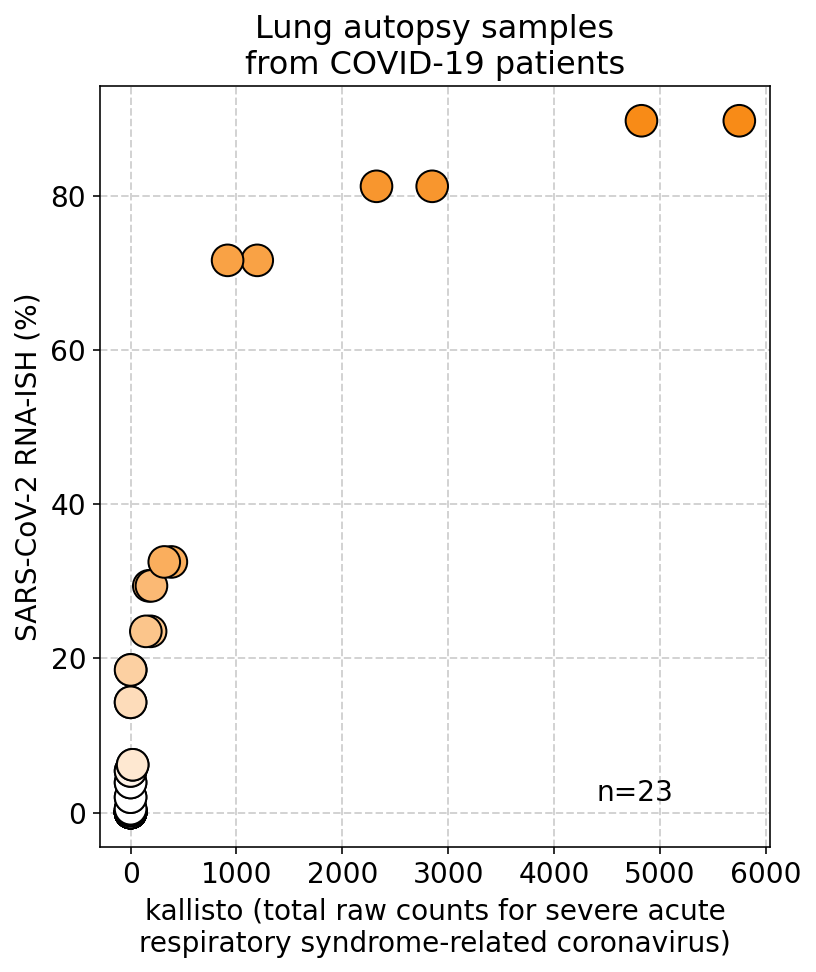

In [128]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 14

# # Replicate colors
# clist = ["white", "white", "white","white","white","white","white","white","white","white","white","white","white","white","white","powderblue","cornflowerblue","royalblue","midnightblue", "moccasin", "gold", "orange", "#f77f00"]

kb_counts = []
rnaish_counts = []
colors = []

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].values

# Not including Control since there are no RNAish% values for control
for i, case in enumerate(case_list[1:]):
    kb_count_r1 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R1"), adata.var.index.isin(target_ids)].X
    kb_count_r2 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R2"), adata.var.index.isin(target_ids)].X
    
    kb_counts.append(kb_count_r1.sum())
    kb_counts.append(kb_count_r2.sum())
    
    # Append twice for R1 and R2
    rnaish_counts.append(rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0])
    rnaish_counts.append(rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0])
        
    colors.append(i)
    colors.append(i)
    
    # colors.append(clist[i])
    # colors.append(clist[i])

norm = plt.Normalize(12, len(case_list[1:]))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "#f77f00"])
ax.scatter(kb_counts, rnaish_counts, c=colors, cmap=cmap, norm=norm, edgecolors="black", s=250, zorder=2)
# ax.scatter(kb_counts, rnaish_counts, c=colors, edgecolors="black", s=250, zorder=2)

# ax.set_xscale("symlog")
ax.set_ylabel("SARS-CoV-2 RNA-ISH (%)", fontsize=fontsize)
ax.set_xlabel(
    "kallisto (total raw counts for severe acute\nrespiratory syndrome-related coronavirus)",
    fontsize=fontsize,
)

ax.text(4400, 1.5, "n=23", fontsize=fontsize)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="-", lw=1, zorder=1)
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Lung autopsy samples\nfrom COVID-19 patients", fontsize=fontsize+2)
    
# plt.tight_layout()

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("figures/bulk_benchmark_PRJNA631753.png", dpi=300, bbox_inches="tight")

fig.show()

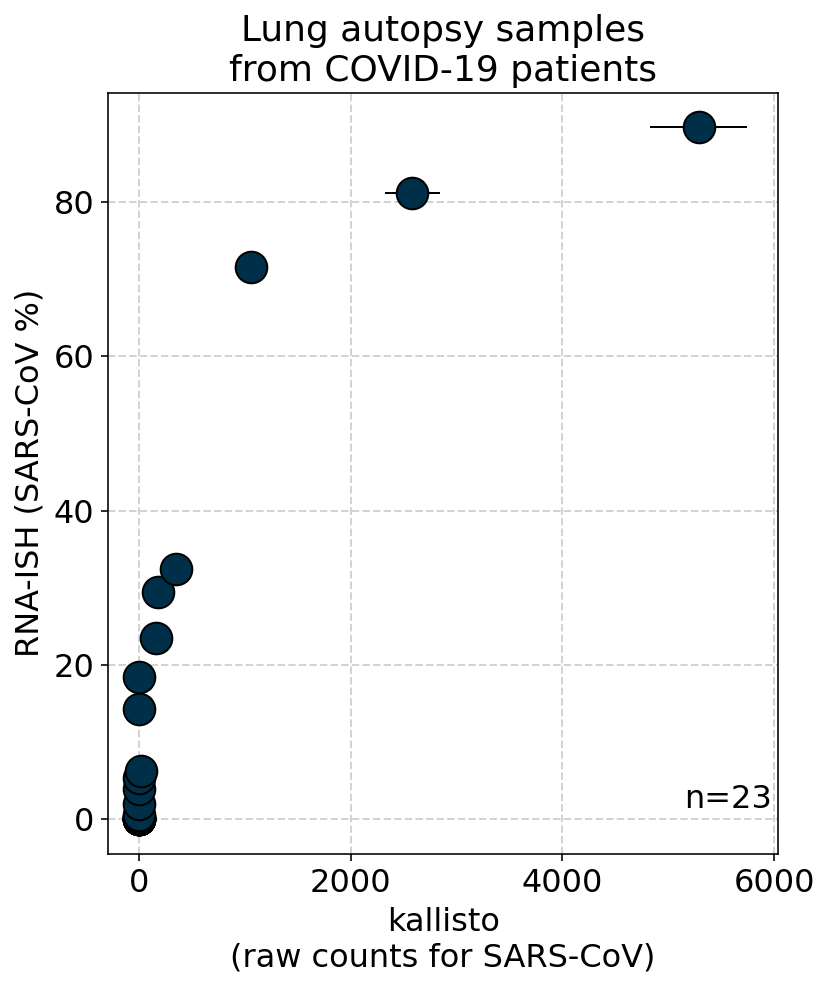

In [130]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].values

kb_counts = []
kb_errs = []
rnaish_counts = []
# Not including Control since there are no RNAish% values for control
for i, case in enumerate(case_list[1:]):
    kb_count_r1 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R1"), adata.var.index.isin(target_ids)].X
    kb_count_r2 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R2"), adata.var.index.isin(target_ids)].X
    
    kb_c = [kb_count_r1.sum(), kb_count_r2.sum()]
    count_mean = np.mean(kb_c)
    kb_counts.append(np.mean(kb_c))

    kb_err = [
        [count_mean - np.min(kb_c)],
        [np.max(kb_c) - count_mean],
    ]
    kb_errs.append(kb_err)
    
    rnaish_count = rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0]
    rnaish_counts.append(rnaish_count)

    ax.errorbar(count_mean, rnaish_count, xerr = kb_err, c= "black", ls="none", elinewidth=1)
    ax.scatter(count_mean, rnaish_count, c="#003049", edgecolors="black", s=250, zorder=2)

# ax.set_yscale("symlog")
# ax.set_xscale("symlog")
ax.set_ylabel("RNA-ISH (SARS-CoV %)", fontsize=fontsize)
ax.set_xlabel(
    "kallisto\n(raw counts for SARS-CoV)",
    fontsize=fontsize,
)

ax.text(5150, 1.5, "n=23", fontsize=fontsize)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="-", lw=1, zorder=1)
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Lung autopsy samples\nfrom COVID-19 patients", fontsize=fontsize+2)
    
# plt.tight_layout()

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("figures/bulk_benchmark_PRJNA631753_v2.png", dpi=300, bbox_inches="tight")

fig.show()

In [72]:
# fig, ax = plt.subplots(figsize=(6, 7))
# fontsize = 14

# target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

# kb_counts = []
# kb_errs = []
# rnaish_counts = []
# # Not including Control since there are no RNAish% values for control
# for i, case in enumerate(case_list[1:]):
#     kb_count_r1 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R1"), adata.var.index.isin(target_ids)].X
#     kb_count_r2 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R2"), adata.var.index.isin(target_ids)].X
    
#     kb_c = [kb_count_r1.sum(), kb_count_r2.sum()]
#     count_mean = np.mean(kb_c)
#     kb_counts.append(np.mean(kb_c))

#     kb_err = [
#         [count_mean - np.min(kb_c)],
#         [np.max(kb_c) - count_mean],
#     ]
#     kb_errs.append(kb_err)
    
#     rnaish_count = rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0]
#     rnaish_counts.append(rnaish_count)

#     ax.errorbar(count_mean, rnaish_count, xerr = kb_err, c= "#f77f00", ls="none", elinewidth=2)
#     ax.scatter(count_mean, rnaish_count, c="#f77f00", edgecolors="black", s=250, zorder=2)


# # Fit a second degree polynomial
# def objective(x, a, b, c):
#     return a * x**2 + b * x + c
    
# # Choose the input and output variables
# x, y = kb_counts, rnaish_counts

# # Curve fit
# popt, _ = curve_fit(objective, x, y)
# a, b, c = popt

# # Define a sequence of inputs between the smallest and largest known inputs
# x_line = np.arange(min(x), max(x), 1)

# # Calculate the output for the range
# y_line = objective(x_line, a, b, c)

# # Add fitted curve to plot
# ax.plot(x_line, y_line)

    
# # ax.set_yscale("symlog")
# # ax.set_xscale("symlog")
# ax.set_ylabel("SARS-CoV-2 RNA-ISH (%)", fontsize=fontsize)
# ax.set_xlabel(
#     "kallisto (total raw counts for severe acute\nrespiratory syndrome-related coronavirus)",
#     fontsize=fontsize,
# )

# ax.text(4400, 1.5, "n=23", fontsize=fontsize)

# # Add diagonal
# # ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="-", lw=1, zorder=1)
        
# ax.tick_params(axis="both", labelsize=fontsize)
# ax.set_title(f"Lung autopsy samples\nfrom COVID-19 patients", fontsize=fontsize+2)
    
# # plt.tight_layout()

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# plt.savefig("figures/bulk_benchmark_PRJNA631753_v2.png", dpi=300, bbox_inches="tight")

# fig.show()

Same figure adjusted for display on black background:

In [73]:
# fig, ax = plt.subplots(figsize=(7, 7))
# fontsize = 18

# kb_counts = []
# rnaish_counts = []
# colors = []

# label_color = "white"

# target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

# # Not including Control since there are no RNAish% values for control
# for i, case in enumerate(case_list[1:]):
#     kb_count_r1 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R1"), adata.var.index.isin(target_ids)].X
#     kb_count_r2 = adata[(adata.obs["case"] == case) & (adata.obs["read"] == "R2"), adata.var.index.isin(target_ids)].X
    
#     kb_counts.append(kb_count_r1.sum())
#     kb_counts.append(kb_count_r2.sum())
    
#     # Append twice for R1 and R2
#     rnaish_counts.append(rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0])
#     rnaish_counts.append(rna_ish[rna_ish["case_clean"] == case]["Viral load% by RNA ISH"].values[0])
        
#     colors.append(i)
#     colors.append(i)

# norm = plt.Normalize(13, len(case_list[1:]))
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "purple"])
# ax.scatter(kb_counts, rnaish_counts, c=colors, cmap=cmap, norm=norm, edgecolor="white", s=200, zorder=2)

# # ax.set_xscale("symlog")
# # ax.set_xlim(left=0.5)
# ax.set_ylabel("RNA-ISH (%)", fontsize=fontsize, color=label_color)
# ax.set_xlabel("Kallisto (total Coronavirus count)", fontsize=fontsize, color=label_color)

# # Add diagonal
# # ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="white", ls="--", lw=1, zorder=1)
        
# ax.tick_params(axis="both", labelsize=fontsize)
# ax.set_title(f"SARS-CoV-2 in lung autopsy\nfrom COVID-19 patients", fontsize=fontsize+2, color=label_color)
    
# # plt.tight_layout()

# ax.grid(True, which="both", color="grey")
# ax.set_axisbelow(True)

# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.tick_params(axis='both', colors='white') 

# plt.savefig("figures/bulk_benchmark_PRJNA631753_white.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()

Remake this figure but instead of having colors depict replicates, use an error bar for replicates and change color to correspond to kb counts:

# 2. VSP data from Ismagilov lab

In [131]:
fastq_folder = "/home/laura/projects/virus-watch-data/alex_ismagilov/VSP"
adata = anndata.read(f"{fastq_folder}/results_cdna_dna/all_VSP.h5ad")
adata

AnnData object with n_obs × n_vars = 88 × 99228
    obs: 'clean_label'

In [132]:
# # samples = [
# #     '3-Rep1_R1', '3-Rep1_R2', '3-Rep2_R1', '3-Rep2_R2', 
# #     '9-Rep1_R1', '9-Rep1_R2', '9-Rep2_R1', '9-Rep2_R2', 
# #     '12-Rep1_R1', '12-Rep1_R2', '12-Rep2_R1', '12-Rep2_R2', 
# #     '15-Rep1_R1', '15-Rep1_R2', '15-Rep2_R1', '15-Rep2_R2', 
# #     '16-Rep1_R1', '16-Rep1_R2', '16-Rep2_R1', '16-Rep2_R2',
    
# # ]

# # # SARS-CoV-2 Viral Load (copies/mL specimen)
# # viral_load = [
# #     2.53E+05, 2.53E+05, 2.53E+05, 2.53E+05,
# #     5.23E+06, 5.23E+06, 5.23E+06, 5.23E+06,
# #     1.10E+10, 1.10E+10, 1.10E+10, 1.10E+10,
# #     4.64E+06, 4.64E+06, 4.64E+06, 4.64E+06,
# #     1.69E+06, 1.69E+06, 1.69E+06, 1.69E+06,
# # ]

# # colors = [
# #     0,0,0,0,
# #     3,3,3,3,
# #     5,5,5,5,
# #     2,2,2,2,
# #     4,4,4,4,
# # ]

# samples = [
#     '3-Rep1_R1', '3-Rep1_R2', '3-Rep2_R1', '3-Rep2_R2', 
#     '9-Rep1_R1', '9-Rep1_R2', '9-Rep2_R1', '9-Rep2_R2', 
#     '12-Rep1_R1', '12-Rep1_R2', '12-Rep2_R1', '12-Rep2_R2', 
#     '15-Rep1_R1', '15-Rep1_R2', '15-Rep2_R1', '15-Rep2_R2', 
#     '16-Rep1_R1', '16-Rep1_R2', '16-Rep2_R1', '16-Rep2_R2',
    
#     '1-Rep1_R1', '1-Rep1_R2', '1-Rep2_R1', '1-Rep2_R2', 
#     '2-Rep1_R1', '2-Rep1_R2', '2-Rep2_R1', '2-Rep2_R2',
#     '4-Rep1_R1', '4-Rep1_R2', '4-Rep2_R1', '4-Rep2_R2',
#     '5-Rep1_R1', '5-Rep1_R2', '5-Rep2_R1', '5-Rep2_R2', 
#     '6-Rep1_R1', '6-Rep1_R2', '6-Rep2_R1', '6-Rep2_R2', 
#     '7-Rep1_R1', '7-Rep1_R2', '7-Rep2_R1', '7-Rep2_R2', 
#     '8-Rep1_R1', '8-Rep1_R2',
#     '10-Rep1_R1', '10-Rep1_R2', '10-Rep2_R1', '10-Rep2_R2',
    
#     '11-Rep1_R1', '11-Rep1_R2', '11-Rep2_R1', '11-Rep2_R2', 
    
#     '13-Rep1_R1', '13-Rep1_R2', '13-Rep2_R1', '13-Rep2_R2', 
#     '14-Rep1_R1', '14-Rep1_R2', '14-Rep2_R1', '14-Rep2_R2',
    
# ]

# # SARS-CoV-2 Viral Load (copies/mL specimen)
# viral_load = [
#     2.53E+05, 2.53E+05, 2.53E+05, 2.53E+05,
#     5.23E+06, 5.23E+06, 5.23E+06, 5.23E+06,
#     1.10E+10, 1.10E+10, 1.10E+10, 1.10E+10,
#     4.64E+06, 4.64E+06, 4.64E+06, 4.64E+06,
#     1.69E+06, 1.69E+06, 1.69E+06, 1.69E+06,
    
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0,
#     0, 0, 0, 0,
    
#     0, 0, 0, 0,
    
#     0, 0, 0, 0,
#     1.76E+06, 1.76E+06, 1.76E+06, 1.76E+06
# ]

# # SARS-CoV2 infected
# colors = [
#     1, 1, 1, 1,
#     1, 1, 1, 1,
#     1, 1, 1, 1,
#     1, 1, 1, 1,
#     1, 1, 1, 1,
    
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 0, 0,
#     0, 0, 
#     0, 0, 0, 0,
    
#     0, 0, 0, 0,
    
#     0, 0, 0, 0,
#     0, 0, 0, 0,
# ]

In [133]:
# fig, ax = plt.subplots(figsize=(7, 7))
# fontsize = 18

# target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

# kb_counts = []
# for case in samples:
#     kb_count = adata[adata.obs["clean_label"] == case, adata.var.index.isin(target_ids)].X
#     kb_counts.append(kb_count.sum())

# norm = plt.Normalize(0, 1)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "tab:red"])
# ax.scatter(kb_counts, viral_load, c=np.array(colors)*2, cmap=cmap, norm=norm, edgecolors="black", s=200, zorder=2, alpha=0.5)

# ax.set_xscale("symlog")
# ax.set_yscale("symlog")
# ax.set_ylabel("RT-qPCR (copies/mL)", fontsize=fontsize)
# ax.set_xlabel("Total counts for severe acute respiratory\nsyndrome-related coronavirus", fontsize=fontsize)

# # Add diagonal
# # ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="--", lw=1, zorder=1)
        
# ax.tick_params(axis="both", labelsize=fontsize)
# ax.set_title(f"Saliva samples from patients\nat different SARS-CoV-2 infection stages", fontsize=fontsize+2)
    
# # plt.tight_layout()

# ax.grid(True, which="both", color="lightgrey")
# ax.set_axisbelow(True)

# plt.savefig("figures/bulk_benchmark_alexVSP.png", dpi=300, bbox_inches="tight")

# fig.show()

In [134]:
rep_list = [
    ["3-Rep1_R1", "3-Rep1_R2", "3-Rep2_R1", "3-Rep2_R2"],
    ["9-Rep1_R1", "9-Rep1_R2", "9-Rep2_R1", "9-Rep2_R2"],
    ["12-Rep1_R1", "12-Rep1_R2", "12-Rep2_R1", "12-Rep2_R2"],
    ["15-Rep1_R1", "15-Rep1_R2", "15-Rep2_R1", "15-Rep2_R2"],
    ["16-Rep1_R1", "16-Rep1_R2", "16-Rep2_R1", "16-Rep2_R2"],
    ["1-Rep1_R1", "1-Rep1_R2", "1-Rep2_R1", "1-Rep2_R2"],
    ["2-Rep1_R1", "2-Rep1_R2", "2-Rep2_R1", "2-Rep2_R2"],
    ["4-Rep1_R1", "4-Rep1_R2", "4-Rep2_R1", "4-Rep2_R2"],
    ["5-Rep1_R1", "5-Rep1_R2", "5-Rep2_R1", "5-Rep2_R2"],
    ["6-Rep1_R1", "6-Rep1_R2", "6-Rep2_R1", "6-Rep2_R2"],
    ["7-Rep1_R1", "7-Rep1_R2", "7-Rep2_R1", "7-Rep2_R2"],
    ["8-Rep1_R1", "8-Rep1_R2"],
    ["10-Rep1_R1", "10-Rep1_R2", "10-Rep2_R1", "10-Rep2_R2"],
    ["11-Rep1_R1", "11-Rep1_R2", "11-Rep2_R1", "11-Rep2_R2"],
    ["13-Rep1_R1", "13-Rep1_R2", "13-Rep2_R1", "13-Rep2_R2"],
    ["14-Rep1_R1", "14-Rep1_R2", "14-Rep2_R1", "14-Rep2_R2"],
]

# SARS-CoV-2 Viral Load (copies/mL specimen)
viral_load = [
    2.53e05,
    5.23e06,
    1.10e10,
    4.64e06,
    1.69e06,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    # 1.76e06, # erroneous metadata label
]

# # colors
# c_indeces = [
#     2,
#     2,
#     2,
#     2,
#     2,
#     1,
#     1,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
# ]

# inf = [
#     "Peak Infection",
#     "Peak Infection",
#     "Peak Infection",
#     "Peak Infection",
#     "Peak Infection",
#     "Pre-Infection",
#     "Pre-Infection",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control",
#     "Uninfected Control"
# ]

# colors
c_indeces = [
    0,
    0,
    1,
    2,
    2,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    2,
]

inf = [
    "Saliva",
    "Saliva",
    "Nasal swab",
    "Throat swab",
    "Throat swab",
    "Saliva",
    "Saliva",
    "Saliva",
    "Saliva",
    "Saliva",
    "Saliva",
    "Saliva",
    "Saliva",
    "Nasal swab",
    "Nasal swab",
    "Throat swab"
]

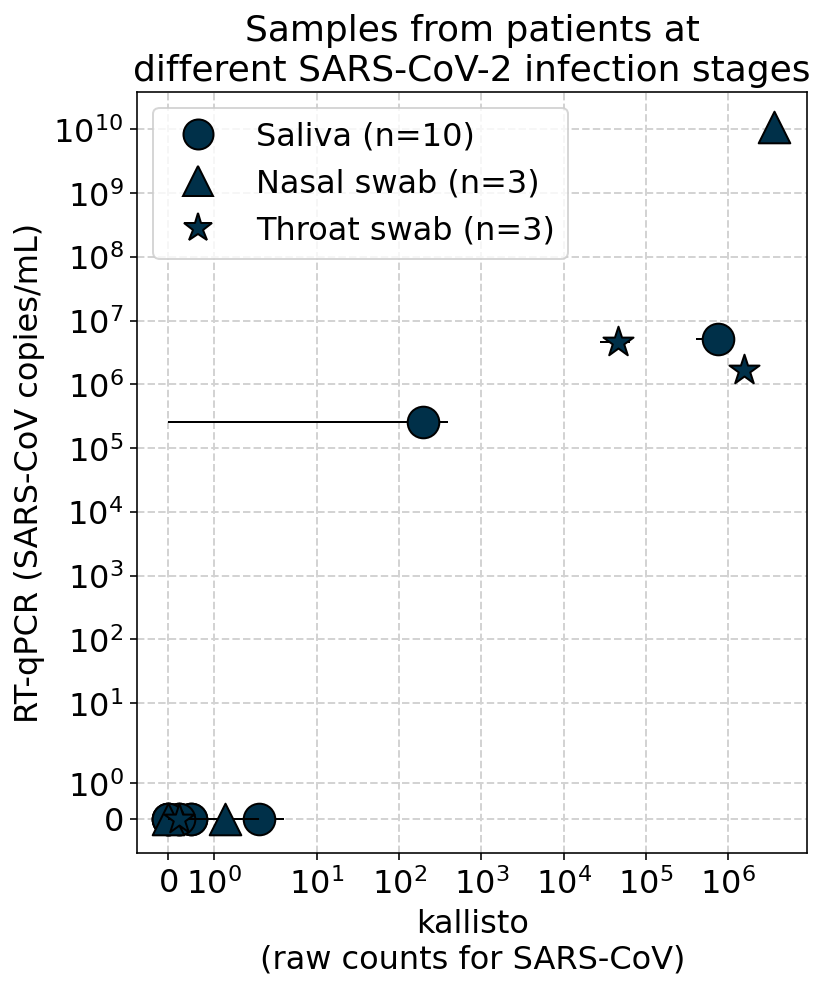

In [135]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16

target_ids = tax_df[
    tax_df["species"].str.contains(
        "Severe acute respiratory syndrome-related coronavirus"
    )
]["rep_ID"].values

markers = ["o", "^", "*"]
fc = "#003049"
ec = "black"

for i, reps in enumerate(rep_list):
    kb_counts = []
    for case in reps:
        kb_count = adata[adata.obs["clean_label"] == case, adata.var.index.isin(target_ids)].X
        kb_counts.append(kb_count.sum())

    xerr = [
        [np.mean(kb_counts) - np.min(kb_counts)],
        [np.max(kb_counts) - np.mean(kb_counts)],
    ]

    ax.errorbar(
        np.mean(kb_counts),
        viral_load[i],
        xerr=xerr,
        ls="none",
        color=ec,
        elinewidth=1,
        alpha=1,
    )

    ax.scatter(
        np.mean(kb_counts),
        viral_load[i],
        color=fc,
        edgecolors=ec,
        marker=markers[c_indeces[i]],
        zorder=2,
        s=250,
        alpha=1,
    )

# Add legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker=markers[0],
        color="none",
        label="Saliva (n=10)",
        markeredgecolor=ec,
        markerfacecolor=fc,
        markersize=15,
    ),
    Line2D(
        [0],
        [0],
        marker=markers[1],
        color="none",
        label="Nasal swab (n=3)",
        markeredgecolor=ec,
        markerfacecolor=fc,
        markersize=15,
    ),
    Line2D(
        [0],
        [0],
        marker=markers[2],
        color="none",
        label="Throat swab (n=3)",
        markeredgecolor=ec,
        markerfacecolor=fc,
        markersize=15,
    ),
]
ax.legend(handles=legend_elements, fontsize=fontsize)

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_ylabel("RT-qPCR (SARS-CoV copies/mL)", fontsize=fontsize)
ax.set_xlabel(
    "kallisto\n(raw counts for SARS-CoV)",
    fontsize=fontsize,
)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="--", lw=1, zorder=1)

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(
    f"Samples from patients at\ndifferent SARS-CoV-2 infection stages",
    fontsize=fontsize + 2,
)

# plt.tight_layout()

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("figures/bulk_benchmark_alexVSP.png", dpi=300, bbox_inches="tight")

fig.show()

In [99]:
# fig, ax = plt.subplots(figsize=(5, 7))
# fontsize = 14

# target_ids = tax_df[
#     tax_df["species"].str.contains(
#         "Severe acute respiratory syndrome-related coronavirus"
#     )
# ]["rep_ID"].values

# err_colors = ["black", "#f77f00", "tab:red"]
# sc_colors = ["white", "#f77f00", "tab:red"]

# for i, reps in enumerate(rep_list):
#     kb_counts = []
#     for case in reps:
#         kb_count = adata[adata.obs["clean_label"] == case, adata.var.index.isin(target_ids)].X
#         kb_counts.append(kb_count.sum())

#     xerr = [
#         [np.mean(kb_counts) - np.min(kb_counts)],
#         [np.max(kb_counts) - np.mean(kb_counts)],
#     ]

#     ax.errorbar(
#         np.mean(kb_counts),
#         viral_load[i],
#         xerr=xerr,
#         ls="none",
#         color=err_colors[c_indeces[i]],
#         alpha=1,
#     )

#     ax.scatter(
#         np.mean(kb_counts),
#         viral_load[i],
#         color=sc_colors[c_indeces[i]],
#         edgecolors="black",
#         zorder=2,
#         s=250,
#         alpha=0.5 if sc_colors[c_indeces[i]] == sc_colors[0] else 1,
#     )

# # Add legend
# legend_elements = [
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="none",
#         label="Peak Infection (n=5)",
#         markeredgecolor="black",
#         markerfacecolor=sc_colors[2],
#         markersize=15,
#     ),
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="none",
#         label="Pre-infection (n=2)",
#         markeredgecolor="black",
#         markerfacecolor=sc_colors[1],
#         markersize=15,
#     ),
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="none",
#         label="Uninfected control (n=9)",
#         markeredgecolor="black",
#         markerfacecolor=sc_colors[0],
#         markersize=15,
#     ),
# ]
# ax.legend(handles=legend_elements, fontsize=fontsize)

# ax.set_xscale("symlog")
# ax.set_yscale("symlog")
# ax.set_ylabel("SARS-CoV-2 RT-qPCR (copies/mL)", fontsize=fontsize)
# ax.set_xlabel(
#     "kallisto (raw counts for SARS-CoV)",
#     fontsize=fontsize,
# )

# # Add diagonal
# # ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="--", lw=1, zorder=1)

# ax.tick_params(axis="both", labelsize=fontsize)
# ax.set_title(
#     f"Saliva, nasal and throat samples from patients\nat different SARS-CoV-2 infection stages",
#     fontsize=fontsize + 2,
# )

# # plt.tight_layout()

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# plt.savefig("figures/bulk_benchmark_alexVSP.png", dpi=300, bbox_inches="tight")

# fig.show()

Same fig adjusted for black bkg:

In [56]:
# fig, ax = plt.subplots(figsize=(7, 7))
# fontsize = 18
# label_color = "white"

# target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

# kb_counts = []
# for case in samples:
#     kb_count = adata[adata.obs["clean_label"] == case, adata.var.index.isin(target_ids)].X
#     kb_counts.append(kb_count.sum())

# norm = plt.Normalize(0, 10)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "purple"])
# ax.scatter(kb_counts, viral_load, c=np.array(colors)*2, cmap=cmap, norm=norm, edgecolors="white", s=200, zorder=2, alpha=0.75)

# ax.set_xscale("symlog")
# ax.set_yscale("symlog")
# ax.set_ylabel("RT-qPCR (copies/mL)", fontsize=fontsize, color=label_color)
# ax.set_xlabel("kallisto (total Coronavirus count)", fontsize=fontsize, color=label_color)

# # Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="white", ls="--", lw=1, zorder=1)
        
# ax.tick_params(axis="both", labelsize=fontsize)
# ax.set_title(f"Saliva samples from patients\nat different SARS-CoV-2 infection stages", fontsize=fontsize+2, color=label_color)
    
# # plt.tight_layout()

# ax.grid(True, which="both", color="grey")
# ax.set_axisbelow(True)

# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.tick_params(axis='both', colors='white') 


# plt.savefig("figures/bulk_benchmark_alexVSP_white.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()

# 3. UHR data from Ismagilov lab

UHR = Universal Human Reference RNA  
HBR = Human Brain Reference RNA

In [57]:
samples_hr = [
    'HBR1ng-10KCVD-Rep1_R1', 'HBR1ng-10KCVD-Rep1_R2',
    'HBR1ng-10KCVD-Rep2_R1', 'HBR1ng-10KCVD-Rep2_R2',
    'HBR10ng-10KCVD-Rep1_R1', 'HBR10ng-10KCVD-Rep1_R2', 
    'HBR10ng-10KCVD-Rep2_R1', 'HBR10ng-10KCVD-Rep2_R2', 
    'HBR1ng-Rep1_R1', 'HBR1ng-Rep1_R2',
    'HBR-1ng-Rep2_R1', 'HBR-1ng-Rep2_R2',
    # 'HBR10ng-Rep1_R1', 'HBR10ng-Rep1_R2',
    
    # 'UHR1ng-Rep1_R1', 'UHR1ng-Rep1_R2',
    # 'UHR-1ng-Rep2_R1', 'UHR-1ng-Rep2_R2',
    # 'UHR1ng-10KCVD-Rep1_R1', 'UHR1ng-10KCVD-Rep1_R2',
    # 'UHR1ng-10KCVD-Rep2_R1', 'UHR1ng-10KCVD-Rep2_R2',
    # 'UHR10ng-10KCVD-Rep1_R1', 'UHR10ng-10KCVD-Rep1_R2',
    # 'UHR10ng-10KCVD-Rep2_R1', 'UHR10ng-10KCVD-Rep2_R2',
]
viral_load_hr = []
for sample in samples_hr:
    if "10KCVD" in sample:
        viral_load_hr.append(10000)
    else:
        viral_load_hr.append(0)

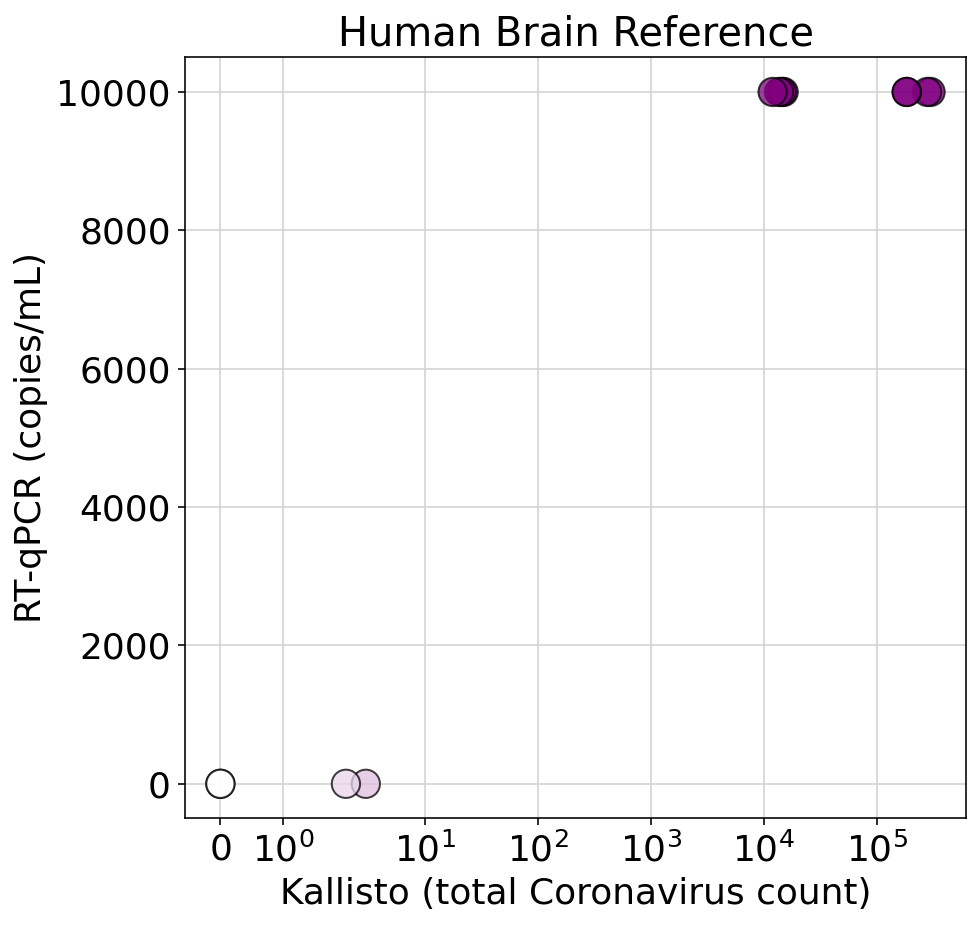

In [58]:
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 18

target_ids = tax_df[
    tax_df["species"].str.contains(
        "Severe acute respiratory syndrome-related coronavirus"
    )
]["rep_ID"].values

kb_counts = []
for case in samples_hr:
    kb_count = adata[adata.obs["clean_label"] == case, adata.var.index.isin(target_ids)].X
    kb_counts.append(kb_count.sum())

norm = plt.Normalize(0, len(kb_counts))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "purple"])
ax.scatter(kb_counts, viral_load_hr, c=kb_counts, cmap=cmap, norm=norm, edgecolors="black", s=200, zorder=2, alpha=0.75)

ax.set_xscale("symlog")
# ax.set_yscale("log")
ax.set_ylabel("RT-qPCR (copies/mL)", fontsize=fontsize)
ax.set_xlabel("Kallisto (total Coronavirus count)", fontsize=fontsize)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="--", lw=1, zorder=1)
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Human Brain Reference", fontsize=fontsize+2)
    
# plt.tight_layout()

ax.grid(True, which="both", color="lightgrey")
ax.set_axisbelow(True)

# plt.savefig("figures/bulk_benchmark_alexHBR.png", dpi=300, bbox_inches="tight")

fig.show()

In [59]:
labels = [
    'Infected 1', 'Infected 2',
    'Infected 3', 'Infected 4',
    'Infected 5', 'Infected 6', 
    'Infected 7', 'Infected 8', 
    'Control 1', 'Control 2',
    'Control 3', 'Control 4',
]

# labels = samples_hr

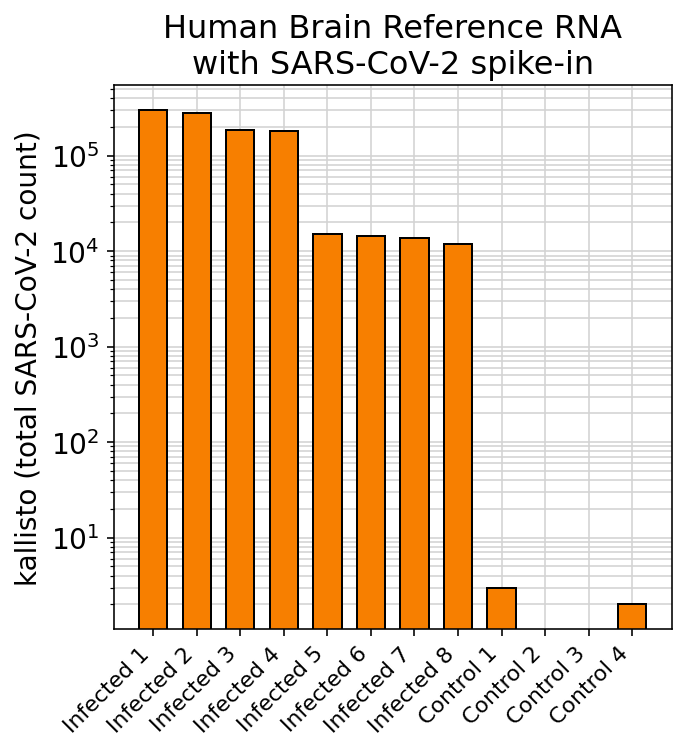

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
fontsize = 14
width = 0.65

target_ids = tax_df[
    tax_df["species"].str.contains(
        "Severe acute respiratory syndrome-related coronavirus"
    )
]["rep_ID"].values

counts = []
for sample in samples_hr:
    count = adata[(adata.obs["clean_label"] == sample), adata.var.index.isin(target_ids)].X
    counts.append(np.sum(count))
        
x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#f77f00", edgecolor="black")

ax.set_yscale("log")
ax.set_ylabel("kallisto (total SARS-CoV-2 count)", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, labels, rotation=45, ha="right", fontsize=fontsize-3)
        
ax.tick_params(axis="y", labelsize=fontsize)
ax.set_title(f"Human Brain Reference RNA\nwith SARS-CoV-2 spike-in", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray")
ax.set_axisbelow(True)
    
# plt.tight_layout()

plt.savefig("figures/bulk_benchmark_alexHBR.png", dpi=300, bbox_inches="tight")

fig.show()

In [61]:
# fig, ax = plt.subplots(figsize=(7, 7))
# fontsize = 18
# width = 0.5
# label_color = "white"

# # target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

# counts = []
# for sample in samples_hr:
#     count = adata[(adata.obs["clean_label"] == sample), adata.var.index.isin(target_ids)].X
#     counts.append(np.sum(count))
        
# x = np.arange(len(labels))

# ax.bar(x, counts, width=width, color="#b266b3")

# ax.set_yscale("log")
# ax.set_ylabel("Kallisto (total Coronavirus count)", fontsize=fontsize, color=label_color)
# ax.set_xlabel("Sample", fontsize=fontsize)

# ax.set_xticks(x, labels, rotation=45, ha="right", fontsize=fontsize-3, color=label_color)
        
# ax.tick_params(axis="y", labelsize=fontsize)
# ax.set_title(f"Human Brain Reference RNA\nwith SARS-CoV-2 spike-in", fontsize=fontsize+2, color=label_color)


# ax.grid(True, which="both", color="grey")
# ax.set_axisbelow(True)

# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.tick_params(axis='both', colors='white') 

# plt.savefig("figures/bulk_benchmark_alexHBR_white.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()